# Business Data Science Kaggle Competition

## Wilshire Liu

In [28]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import collections
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import skew
import warnings

warnings.simplefilter("ignore")
sns.set(style='ticks', palette='Set2')
%matplotlib inline

### I first tried a fitting the data to a basic logistic regression.

In [2]:
df = pd.read_csv('train_final.csv', index_col='Id')
y = df['Y']
X = df.drop('Y', axis=1)

In [3]:
X.head()

f1  f2     f3      f4  f5  f6      f7      f8  f9  f10 ...     f15  \
Id                                                            ...           
1   25884   1  33.63  118596   1   0  118595  125738   1    3 ...    1945   
2   34346   1  10.62  118041   1   0  117902  130913   1    1 ...   15385   
3   34923   1   1.77  118327   1   0  117961  124402   1    2 ...    7547   
4   80926   1  30.09  118300   1   0  117961  301218   1    0 ...    4933   
5    4674   1   1.77  119921   1   0  119920  302830   1    0 ...   13836   

       f16     f17  f18     f19  f20  f21  f22  f23  f24  
Id                                                        
1   118450  119184    1  121372    1    1    1    2    1  
2   117945  292795    1  259173    1    1    1    1    1  
3   118933  290919    1  118784    1    1    1    1    1  
4   118458  118331    1  307024    1    1    1    2    1  
5   142145    4673    1  128230    1    1    1  620    1  

[5 rows x 24 columns]

In [4]:
ones = 0
for i in y:
    if i == 1:
        ones += 1

scale_pos_weight_to_use = (y.count()-ones)/ones

In [5]:
lr = LogisticRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
y_probas = lr.predict_proba(X)

In [6]:
print('Misclassified samples in test set: %d' %(y != y_pred).sum())
from sklearn.metrics import accuracy_score
print('Accuracy: %.5f' % accuracy_score(y,y_pred))

Misclassified samples in test set: 948
Accuracy: 0.94214


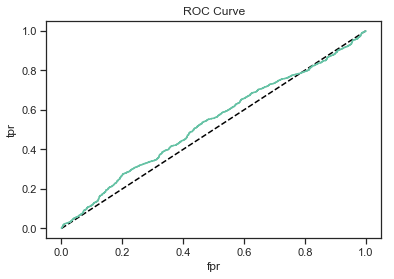

0.5325769970435431

In [7]:
fpr, tpr, thresholds = roc_curve(y, y_probas[:, 1])

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.show()

roc_auc_score(y, y_probas[:, 1])

### Accuracy was pretty good, but AUC was pretty bad meaning the model is really not that good. Close to 0.5 AUC means the model is basically just as good as guessing.

# Try train/test split

### I then tried to implement a train/test split myself (I use CV later). I decided to do this because I could then have a train set and also a validation set to try to tune the hyperparameters on.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Try XGBoost

### I then realized that XGBoost is probably the best model to use.

# XGBoost tuning hyperparameters with validation set AUC

### At this point, I didn't think of using GridSearchCV or RandomizedSearchCV, so I just manually implemented hyperparameter searching based on the validation set AUC score. Also, I didn't think to change the n_estimators parameter until later.

In [ ]:
max_depth=[1,2,3,4,5,6,7,8,9,10]
min_child_weight=[1,2,3,4,5,6,7,8,9,10]
gamma=[1,2,3,4,5,6,7,8,9,10]
scale_pos_weight=[scale_pos_weight_to_use,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

rocs = {}

for i in max_depth:
    for j in min_child_weight:
        for k in gamma:
            for s in scale_pos_weight:
                xgb_model = XGBClassifier(max_depth=i,min_child_weight=j,gamma=k,scale_pos_weight=s)
                xgb_model.fit(X_train, y_train)
                y_probas = xgb_model.predict_proba(X_test)
                key = 'max_depth=' + str(i) + ' ' + 'min_child_weight=' + str(j) + ' ' + 'gamma=' + str(k) + ' ' + 'scale_pos_weight=' + str(s)
                rocs[key] = (roc_auc_score(y_test, y_probas[:, 1]))
                print(key, rocs[key])
    rocs

max_depth=1 min_child_weight=1 gamma=1 scale_pos_weight=0.06141885325558795 0.7903782818800209
max_depth=1 min_child_weight=1 gamma=1 scale_pos_weight=0.1 0.7891578688171381
max_depth=1 min_child_weight=1 gamma=1 scale_pos_weight=0.2 0.7902844039521069
max_depth=1 min_child_weight=1 gamma=1 scale_pos_weight=0.3 0.7860306565299023
max_depth=1 min_child_weight=1 gamma=1 scale_pos_weight=0.4 0.7855204838560743
max_depth=1 min_child_weight=1 gamma=1 scale_pos_weight=0.5 0.7855974329773154
max_depth=1 min_child_weight=1 gamma=1 scale_pos_weight=0.6 0.7850926467419743
max_depth=1 min_child_weight=1 gamma=1 scale_pos_weight=0.7 0.7770414601865246
max_depth=1 min_child_weight=1 gamma=1 scale_pos_weight=0.8 0.7771291821847395
max_depth=1 min_child_weight=1 gamma=1 scale_pos_weight=0.9 0.776421250269322
max_depth=1 min_child_weight=1 gamma=1 scale_pos_weight=1 0.7734664040136663


### I stopped the searching early to preserve space on this report

In [24]:
backup = pd.read_csv('backup.csv')
sortedAucs = backup.sort_values(by=['auc'],ascending=False)
sortedAucs.head(10)
sortedAucs.to_csv('sortedaucs.csv')

In [9]:
xgb_model = XGBClassifier(max_depth=10,min_child_weight=1,gamma=8,scale_pos_weight=.6)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=8, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.6, seed=None,
       silent=True, subsample=1)

### This was the model that had the highest validation score based on my manual implemetation of hyperparameter searching.

In [10]:
y_pred = xgb_model.predict(X_train)
y_probas = xgb_model.predict_proba(X_train)

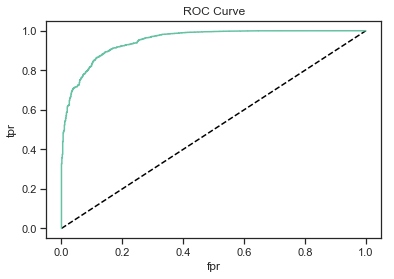

0.9502658627991987

In [11]:
fpr, tpr, thresholds = roc_curve(y_train, y_probas[:, 1])

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.show()

roc_auc_score(y_train, y_probas[:, 1])

In [12]:
y_pred = xgb_model.predict(X_test)
y_probas = xgb_model.predict_proba(X_test)

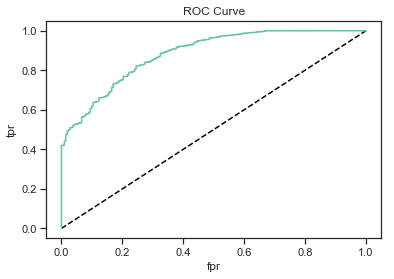

0.882928067961464

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas[:, 1])

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.show()

roc_auc_score(y_test, y_probas[:, 1])

### Train AUC was pretty good, but validation AUC was worse, which means the model is overfitting. This model was giving about .86 AUC on Kaggle.

# Cross Validate

### I then realized that I could just use CV or GridSearchCV to search for hyperparameters...

In [41]:
xgb_model = XGBClassifier(max_depth=10,min_child_weight=1,gamma=1,scale_pos_weight=.6,subsample=0.5,n_estimators=1000)
scores = cross_val_score(xgb_model, X, y, cv=5, scoring='roc_auc')
scores

array([0.85470308, 0.85023613, 0.88345524, 0.85975751, 0.8883627 ])

### I increased n_estimators to 1000, which did give me a better score on Kaggle (around 0.87)

In [6]:
parameters = {'booster':['dart'],'max_depth':[25],'scale_pos_weight':[.8],'gamma':[9],'subsample':[0.5,0.6],'min_child_weight':[1,2],'n_estimators':[2000],'max_delta_step':[3,5]}
grid = GridSearchCV(XGBClassifier(), param_grid=parameters, cv=5, scoring='roc_auc')
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'booster': ['dart'], 'max_depth': [25], 'scale_pos_weight': [0.8], 'gamma': [9], 'subsample': [0.5, 0.6], 'min_child_weight': [1, 2], 'n_estimators': [2000], 'max_delta_step': [3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [4]:
print(grid.best_params_)
print(grid.best_score_)
#print(grid.cv_results_)

{'gamma': 9, 'max_delta_step': 3, 'max_depth': 25, 'min_child_weight': 2, 'n_estimators': 2000, 'scale_pos_weight': 0.8, 'subsample': 0.6}
0.8680515841335036


In [ ]:
xgb_model = XGBClassifier(booster='dart',max_depth=25,min_child_weight=1,gamma=9,scale_pos_weight=.8,subsample=0.6,n_estimators=2000)
xgb_model.fit(X, y)

### I also learned that I should use the dart booster instead of gbtree because it helps with overfitting by dropping some of the trees. This increased my Kaggle score to up to almost .88... I also decided to try 2000 n_estimators and it did do better than 1000 n_estimators. I think this is because it's averaging over more estimators which should help with the overfitting.

In [9]:
xgb_model = XGBClassifier(booster='dart',max_depth=24,min_child_weight=1,gamma=9,scale_pos_weight=.8,subsample=0.6,n_estimators=1500)
xgb_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=9, learning_rate=0.1, max_delta_step=0,
       max_depth=24, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.8, seed=None,
       silent=True, subsample=0.6)

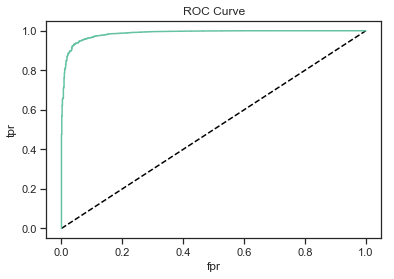

0.9866825492503613

In [16]:
y_probas = xgb_model.predict_proba(X)

fpr, tpr, thresholds = roc_curve(y, y_probas[:, 1])

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.show()

roc_auc_score(y, y_probas[:, 1])

In [20]:
test = pd.read_csv('test_final.csv', index_col='Id')

In [21]:
y_probas = xgb_model.predict_proba(test)
y_probas[:,1]

array([0.8826229 , 0.85601693, 0.9982153 , ..., 0.99851483, 0.9627084 ,
       0.8834329 ], dtype=float32)

In [22]:
submission = pd.DataFrame({'Id':test.index,'Y':y_probas[:,1]}).set_index('Id')

In [23]:
submission.to_csv('submission.csv')

### However, I tried 1,500 n_estimators because I thought maybe 2000 was a little too much, and it actually increased my Kaggle AUC by a tiny bit. This is the best model that I could fit (AUC of 0.88058 public score on Kaggle). The other parameters I set the model to were chosen from my manually implemented hyperparameter search and also trying many different GridSearchCVs. 1,500 n_estimators is probably close to the optimal point where variance is reduced (based on the other parameters I used).

# Feature Selection

# Combine train and test set, make dummies, then split back

### I then tried to make dummy variables for the columns that seemed like they were categorical values.

In [11]:
train = pd.read_csv('train_final.csv', index_col='Id')
test = pd.read_csv('test_final.csv', index_col='Id')
y = train['Y']
X = train.drop('Y', axis=1)

In [12]:
all_data = pd.concat([X, test])
all_data.head(10)

f1  f2     f3      f4  f5  f6      f7      f8  f9  f10 ...     f15  \
Id                                                            ...           
1   25884   1  33.63  118596   1   0  118595  125738   1    3 ...    1945   
2   34346   1  10.62  118041   1   0  117902  130913   1    1 ...   15385   
3   34923   1   1.77  118327   1   0  117961  124402   1    2 ...    7547   
4   80926   1  30.09  118300   1   0  117961  301218   1    0 ...    4933   
5    4674   1   1.77  119921   1   0  119920  302830   1    0 ...   13836   
6   31824   1   3.54  118300   1   0  117961  154949   1    3 ...    3085   
7   25889   1   3.54  118225   1   0  117961  120324   1    1 ...    3526   
8   80867   1   1.77  121006   1   0  121005  164523   1   10 ...    1383   
9   17225   1  23.01  118386   1   0  117961  269406   1    0 ...    5249   
10  45142   1   1.77  118052   1   0  117961  121809   1    0 ...   15904   

       f16     f17  f18     f19  f20  f21  f22  f23  f24  
Id                                                        
1   118450  119184    1  121372    1    1    1    2    1  
2   117945  292795    1  259173    1    1    1    1    1  
3   118933  290919    1  118784    1    1    1    1    1  
4   118458  118331    1  307024    1    1    1    2    1  
5   142145    4673    1  128230    1    1    1  620    1  
6   125821  118638    1  119849    1    1    1    2    1  
7   120323  119095    1  122849    1    1    1    1    1  
8   118575  121916    1  122129    1    1    1    1    1  
9   123144  118398    1  118396    1    1    1    2    1  
10  118053  118638    1  118636    1    1    1    9    1  

[10 rows x 24 columns]

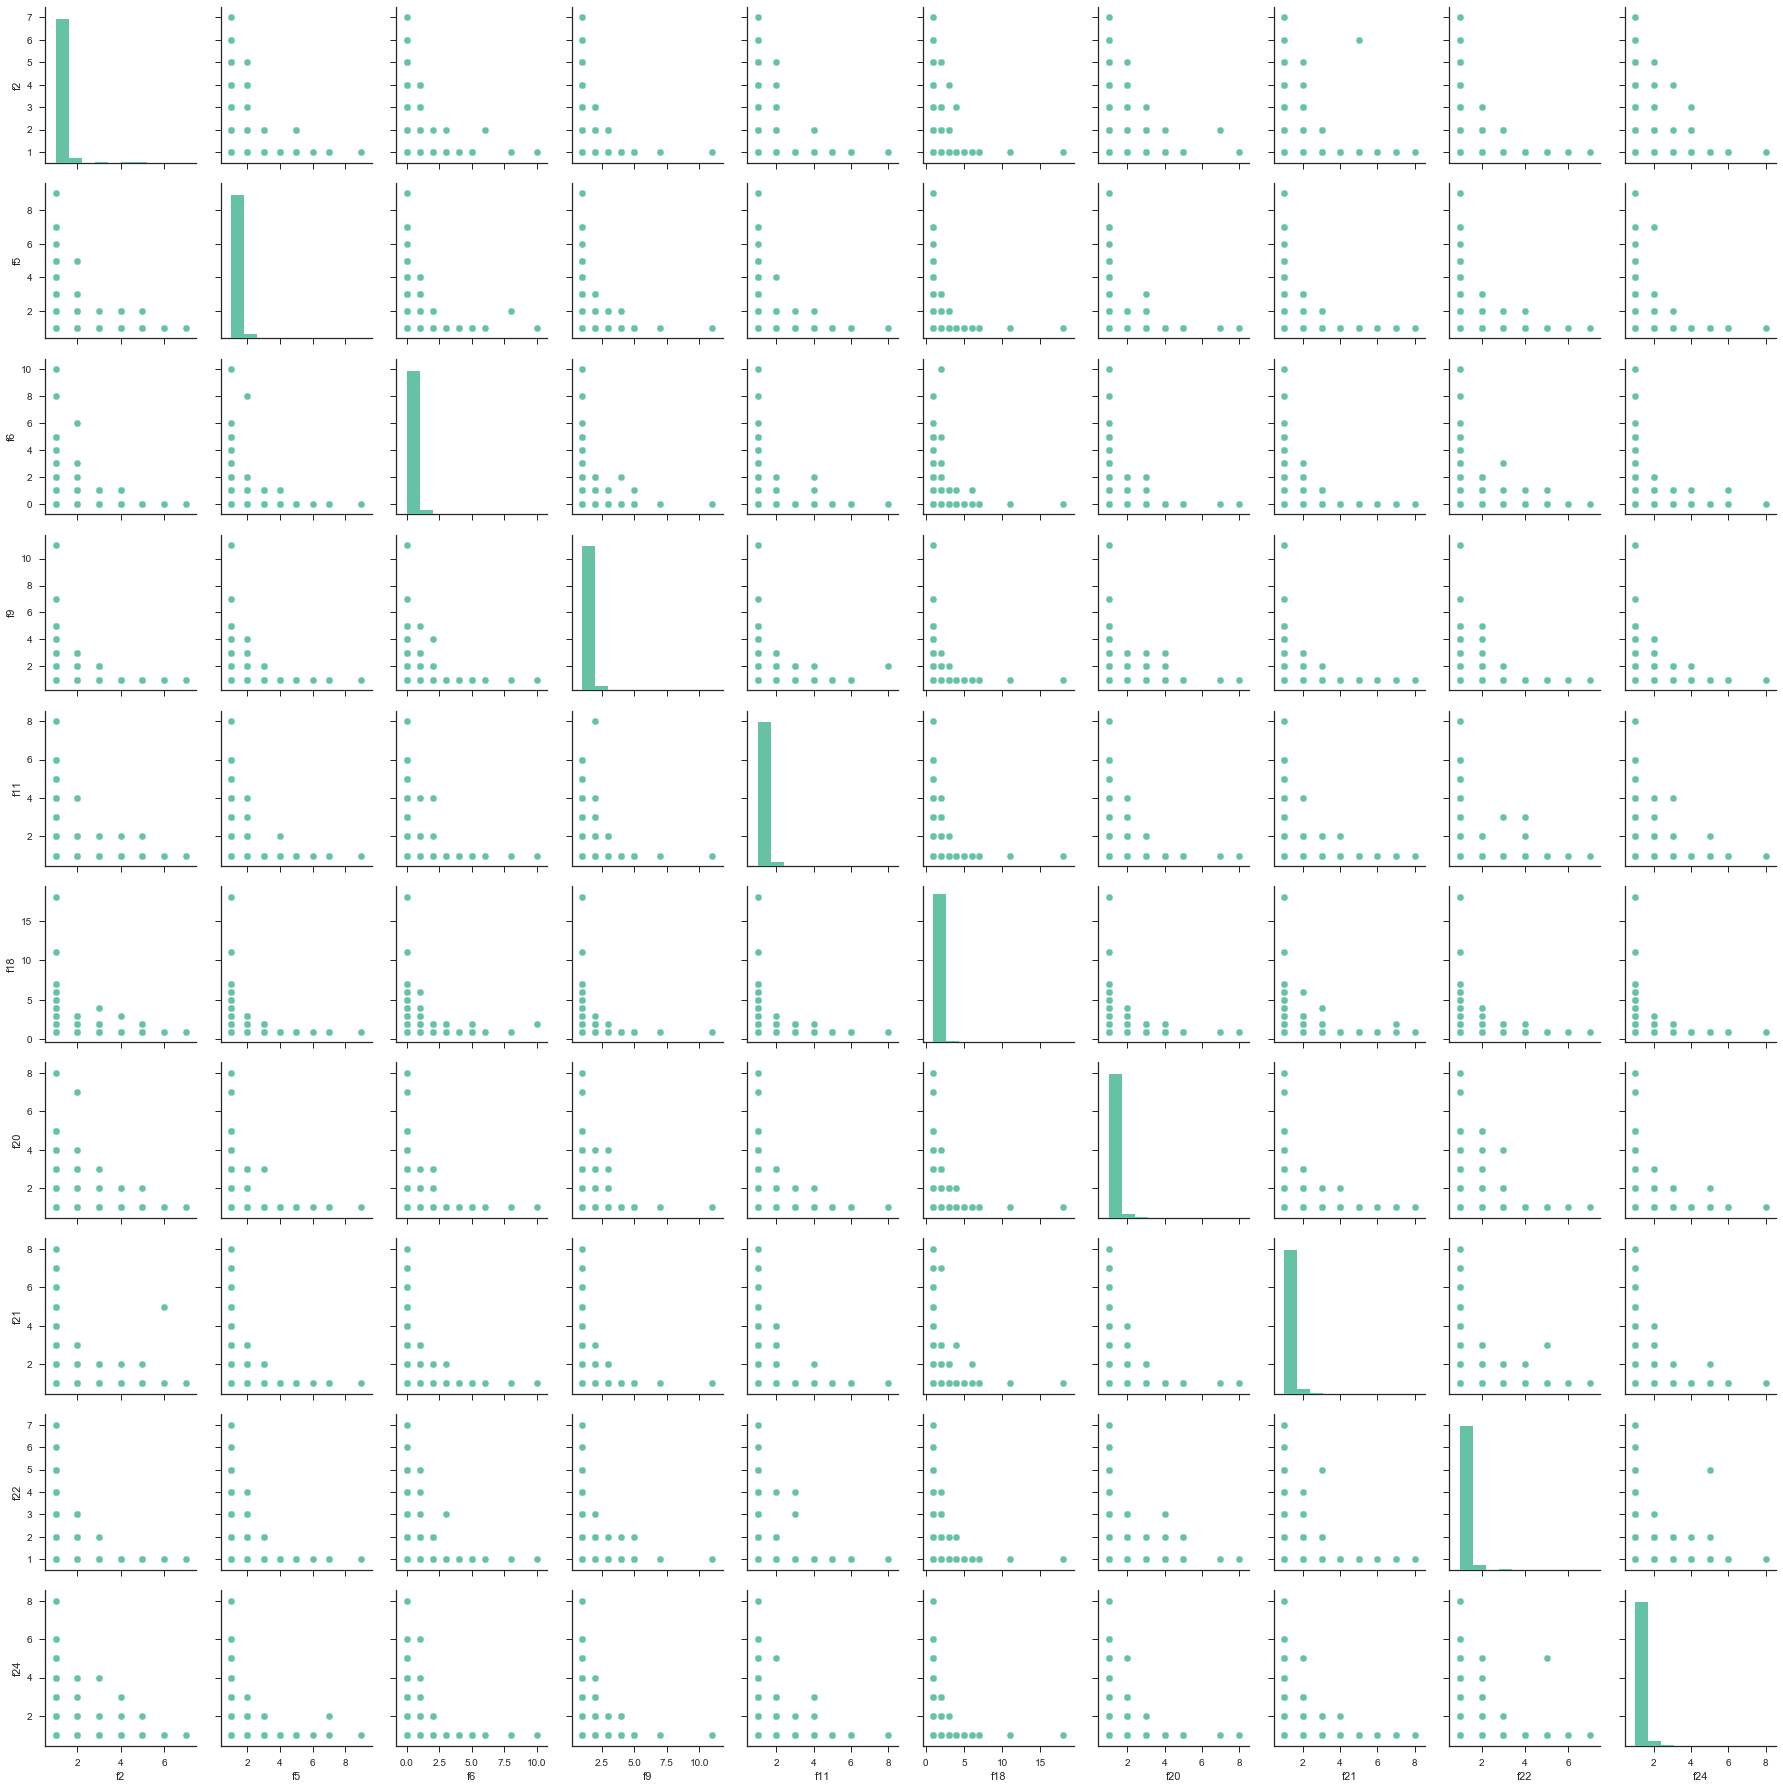

In [27]:
sns.pairplot(df[['f2','f5', 'f6', 'f9', 'f11', 'f18', 'f20', 'f21', 'f22', 'f24']])
sns.despine()

### These were the columns that didn't have that many different values, so I chose to make dummy variables out of them. I decided to do this because I didn't want to create too many new columns, but at the same time, I wanted to make sure I found the the columns that are categorical variables (if they are in this case).

In [13]:
# get_dummies
all_data_dummies = pd.get_dummies(all_data, columns=['f2','f5', 'f6', 'f9', 'f11', 'f18', 'f20', 'f21', 'f22', 'f24'])
all_data_dummies.columns

Index(['f1', 'f3', 'f4', 'f7', 'f8', 'f10', 'f12', 'f13', 'f14', 'f15', 'f16',
       'f17', 'f19', 'f23', 'f2_1', 'f2_2', 'f2_3', 'f2_4', 'f2_5', 'f2_6',
       'f2_7', 'f2_17', 'f5_1', 'f5_2', 'f5_3', 'f5_4', 'f5_5', 'f5_6', 'f5_7',
       'f5_9', 'f5_12', 'f6_0', 'f6_1', 'f6_2', 'f6_3', 'f6_4', 'f6_5', 'f6_6',
       'f6_8', 'f6_10', 'f6_24', 'f9_1', 'f9_2', 'f9_3', 'f9_4', 'f9_5',
       'f9_6', 'f9_7', 'f9_8', 'f9_9', 'f9_10', 'f9_11', 'f11_1', 'f11_2',
       'f11_3', 'f11_4', 'f11_5', 'f11_6', 'f11_8', 'f18_1', 'f18_2', 'f18_3',
       'f18_4', 'f18_5', 'f18_6', 'f18_7', 'f18_11', 'f18_18', 'f20_1',
       'f20_2', 'f20_3', 'f20_4', 'f20_5', 'f20_6', 'f20_7', 'f20_8', 'f21_1',
       'f21_2', 'f21_3', 'f21_4', 'f21_5', 'f21_6', 'f21_7', 'f21_8', 'f21_12',
       'f22_1', 'f22_2', 'f22_3', 'f22_4', 'f22_5', 'f22_6', 'f22_7', 'f24_1',
       'f24_2', 'f24_3', 'f24_4', 'f24_5', 'f24_6', 'f24_8', 'f24_16'],
      dtype='object')

In [14]:
# split back into train/test
train_dummies = all_data_dummies.iloc[:16383]
#train_dummies.head(10)
test_dummies = all_data_dummies.iloc[16383:]
#test_dummies.head(10)

In [11]:
xgb_model = XGBClassifier(booster='dart',max_depth=100,min_child_weight=2,gamma=9,scale_pos_weight=.8,subsample=0.6,n_estimators=2000,max_delta_step=3)
xgb_model.fit(train_dummies, y)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=9, learning_rate=0.1,
       max_delta_step=3, max_depth=100, min_child_weight=2, missing=None,
       n_estimators=2000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.8, seed=None, silent=None,
       subsample=0.6, verbosity=1)

### This model got an AUC of 0.86989 on Kaggle, which is worse than my best model where I didn't use any dummy variables. My assumption is that creating dummy variables overfits more because there are many more features that the tree has to find a split on. Each tree is more complex, and therefore, it can overfit to the training data more.

In [28]:
X_drop = X.drop(['f2','f5', 'f6', 'f9', 'f11', 'f18', 'f20', 'f21', 'f22', 'f24'], axis=1)
X_drop.head(10)

f1     f3      f4      f7      f8  f10  f12     f13       f14    f15  \
Id                                                                            
1   25884  33.63  118596  118595  125738    3    2  121374 -2.266430   1945   
2   34346  10.62  118041  117902  130913    1   23  118943 -0.305612  15385   
3   34923   1.77  118327  117961  124402    2    1  118786  2.015561   7547   
4   80926  30.09  118300  117961  301218    0    1  118332 -3.172501   4933   
5    4674   1.77  119921  119920  302830    0    2  128231  0.573767  13836   
6   31824   3.54  118300  117961  154949    3    1  119851  1.000000   3085   
7   25889   3.54  118225  117961  120324    1    1  122850  1.000000   3526   
8   80867   1.77  121006  121005  164523   10    6  122131 -1.641212   1383   
9   17225  23.01  118386  117961  269406    0    1  118399  1.947557   5249   
10  45142   1.77  118052  117961  121809    0    9  118639 -0.369777  15904   

       f16     f17     f19  f23  
Id                               
1   118450  119184  121372    2  
2   117945  292795  259173    1  
3   118933  290919  118784    1  
4   118458  118331  307024    2  
5   142145    4673  128230  620  
6   125821  118638  119849    2  
7   120323  119095  122849    1  
8   118575  121916  122129    1  
9   123144  118398  118396    2  
10  118053  118638  118636    9

# Logging skewed features

### I then tried to log the skewed features to see if the model could predict better and thus prevent overfitting.

In [29]:
train = pd.read_csv('train_final.csv', index_col='Id')
test = pd.read_csv('test_final.csv', index_col='Id')
y = train['Y']
X = train.drop('Y', axis=1)
all_data = pd.concat([X, test])

In [30]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
#print(numeric_feats)

skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
#print(skewed_feats)
skewed_feats = skewed_feats[skewed_feats > 0.75]
#print(skewed_feats)
skewed_feats = skewed_feats.index
print(skewed_feats)

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data.head(10)

Index(['f1', 'f2', 'f3', 'f5', 'f6', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13',
       'f15', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24'],
      dtype='object')


f1        f2        f3      f4        f5   f6      f7         f8  \
Id                                                                            
1   10.161419  0.693147  3.544720  118596  0.693147  0.0  118595  11.741964   
2   10.444270  0.693147  2.452728  118041  0.693147  0.0  117902  11.782296   
3   10.460930  0.693147  1.018847  118327  0.693147  0.0  117961  11.731282   
4   11.301303  0.693147  3.436886  118300  0.693147  0.0  117961  12.615593   
5    8.449984  0.693147  1.018847  119921  0.693147  0.0  119920  12.620930   
6   10.368007  0.693147  1.512927  118300  0.693147  0.0  117961  11.950858   
7   10.161612  0.693147  1.512927  118225  0.693147  0.0  117961  11.697952   
8   11.300573  0.693147  1.018847  121006  0.693147  0.0  121005  12.010812   
9    9.754175  0.693147  3.178470  118386  0.693147  0.0  117961  12.503979   
10  10.717591  0.693147  1.018847  118052  0.693147  0.0  117961  11.710218   

          f9       f10    ...          f15     f16     f17       f18  \
Id                        ...                                          
1   0.693147  1.386294    ...     7.573531  118450  119184  0.693147   
2   0.693147  0.693147    ...     9.641213  117945  292795  0.693147   
3   0.693147  1.098612    ...     8.929038  118933  290919  0.693147   
4   0.693147  0.000000    ...     8.503905  118458  118331  0.693147   
5   0.693147  0.000000    ...     9.535101  142145    4673  0.693147   
6   0.693147  1.386294    ...     8.034631  125821  118638  0.693147   
7   0.693147  0.693147    ...     8.168203  120323  119095  0.693147   
8   0.693147  2.397895    ...     7.232733  118575  121916  0.693147   
9   0.693147  0.000000    ...     8.565983  123144  118398  0.693147   
10  0.693147  0.000000    ...     9.674389  118053  118638  0.693147   

          f19       f20       f21       f22       f23       f24  
Id                                                               
1   11.706624  0.693147  0.693147  0.693147  1.098612  0.693147  
2   12.465255  0.693147  0.693147  0.693147  0.693147  0.693147  
3   11.685070  0.693147  0.693147  0.693147  0.693147  0.693147  
4   12.634684  0.693147  0.693147  0.693147  1.098612  0.693147  
5   11.761589  0.693147  0.693147  0.693147  6.431331  0.693147  
6   11.693996  0.693147  0.693147  0.693147  1.098612  0.693147  
7   11.718719  0.693147  0.693147  0.693147  0.693147  0.693147  
8   11.712841  0.693147  0.693147  0.693147  0.693147  0.693147  
9   11.681799  0.693147  0.693147  0.693147  1.098612  0.693147  
10  11.683824  0.693147  0.693147  0.693147  2.302585  0.693147  

[10 rows x 24 columns]

In [31]:
# split back into train/test
X = all_data.iloc[:16383]
test = all_data.iloc[16383:]

In [5]:
xgb_model = XGBClassifier(booster='dart',max_depth=24,min_child_weight=1,gamma=9,scale_pos_weight=.8,subsample=0.6,n_estimators=1500)
xgb_model.fit(X, y)


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=9, learning_rate=0.1, max_delta_step=0,
       max_depth=24, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.8, seed=None,
       silent=True, subsample=0.6)

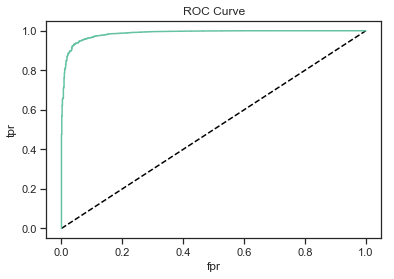

0.9866825492503613

In [6]:
y_probas = xgb_model.predict_proba(X)
# ROC on train set... need to predict on test set
fpr, tpr, thresholds = roc_curve(y, y_probas[:, 1])

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.show()

roc_auc_score(y, y_probas[:, 1])

### Kaggle AUC score of 0.87388. This is still not an improvement. Perhaps, logging some of the skewed features doesn't really help with the overfitting. I think it's because there are so too many columns and none of them are actually that great of predictors for the model.

# Try Stacking

### I then tried stacking. I added the prediction of my best model as one of the features, and then trained another model with the same parameters as that best model.

In [20]:
xgb_model = XGBClassifier(booster='dart',max_depth=24,min_child_weight=1,gamma=9,scale_pos_weight=.8,subsample=0.6,n_estimators=1500)
xgb_model.fit(X, y)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=9, learning_rate=0.1, max_delta_step=0,
       max_depth=24, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.8, seed=None,
       silent=True, subsample=0.6)

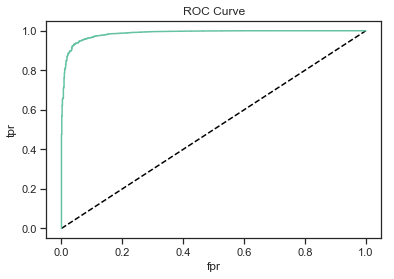

0.9866825492503613

In [21]:
y_probas = xgb_model.predict_proba(X)
# ROC on train set... need to predict on test set
fpr, tpr, thresholds = roc_curve(y, y_probas[:, 1])

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.show()

roc_auc_score(y, y_probas[:, 1])

In [22]:
y_pred = xgb_model.predict(X)
X_stack1 = X.copy()
X_stack1['xgb_model1'] = y_pred
#X_stack1

In [23]:
xgb_model_stack1 = XGBClassifier(booster='dart',max_depth=25,min_child_weight=1,gamma=9,scale_pos_weight=.8,subsample=0.6,n_estimators=1500)
xgb_model_stack1.fit(X_stack1, y)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=9, learning_rate=0.1, max_delta_step=0,
       max_depth=25, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.8, seed=None,
       silent=True, subsample=0.6)

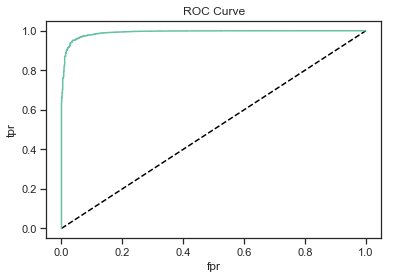

0.9913711576653969

In [24]:
y_probas = xgb_model_stack1.predict_proba(X_stack1)
# ROC on train set... need to predict on test set
fpr, tpr, thresholds = roc_curve(y, y_probas[:, 1])

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.show()

roc_auc_score(y, y_probas[:, 1])

In [25]:
test = pd.read_csv('test_final.csv', index_col='Id')

In [26]:
y_pred_test = xgb_model.predict(test)
test_stack1 = test.copy()
test_stack1['xgb_model1'] = y_pred_test
#test_stack1

In [27]:
y_probas_test = xgb_model_stack1.predict_proba(test_stack1)
y_probas_test[:,1]

array([0.88480836, 0.926687  , 0.9986436 , ..., 0.9974009 , 0.9515858 ,
       0.9698776 ], dtype=float32)

In [28]:
submission = pd.DataFrame({'Id':test.index,'Y':y_probas_test[:,1]}).set_index('Id')

In [29]:
submission.to_csv('submission.csv')

### Of course, this increased the training AUC, but it lowered the Kaggle (test) AUC. This stacked model got an AUC of 0.87097 on Kaggle. This makes sense though because stacking is usually used to make the training of the model more robust, and this usually leads to overfitting.

# Try dropping some features

### I then tried dropping some of the features that were highly imbalanced. E.g. a feature that had mostly 1's or 0's.

In [2]:
train = pd.read_csv('train_final.csv', index_col='Id')
test = pd.read_csv('test_final.csv', index_col='Id')
y = train['Y']
X = train.drop('Y', axis=1)
all_data = pd.concat([X, test])

### I breifly browsed through the data to see which columns had a high imbalance of values, and these were the columns I found.

In [3]:
all_data_drop = all_data.drop(['f2', 'f5', 'f6', 'f9', 'f11', 'f18', 'f20', 'f21', 'f22', 'f24'], axis=1)
all_data_drop.head(10)

f1     f3      f4      f7      f8  f10  f12     f13       f14    f15  \
Id                                                                            
1   25884  33.63  118596  118595  125738    3    2  121374 -2.266430   1945   
2   34346  10.62  118041  117902  130913    1   23  118943 -0.305612  15385   
3   34923   1.77  118327  117961  124402    2    1  118786  2.015561   7547   
4   80926  30.09  118300  117961  301218    0    1  118332 -3.172501   4933   
5    4674   1.77  119921  119920  302830    0    2  128231  0.573767  13836   
6   31824   3.54  118300  117961  154949    3    1  119851  1.000000   3085   
7   25889   3.54  118225  117961  120324    1    1  122850  1.000000   3526   
8   80867   1.77  121006  121005  164523   10    6  122131 -1.641212   1383   
9   17225  23.01  118386  117961  269406    0    1  118399  1.947557   5249   
10  45142   1.77  118052  117961  121809    0    9  118639 -0.369777  15904   

       f16     f17     f19  f23  
Id                               
1   118450  119184  121372    2  
2   117945  292795  259173    1  
3   118933  290919  118784    1  
4   118458  118331  307024    2  
5   142145    4673  128230  620  
6   125821  118638  119849    2  
7   120323  119095  122849    1  
8   118575  121916  122129    1  
9   123144  118398  118396    2  
10  118053  118638  118636    9

In [4]:
# split back into train/test
X_drop = all_data_drop.iloc[:16383]
test_drop = all_data_drop.iloc[16383:]

### I used RandomizedSearchCV to search for the best hyperparameters using the data with the dropped features

In [5]:
max_depth=[14]
min_child_weight=[1,2,3,4,5,6,7,8,9,10]
gamma=[1,2,3,4,5,6,7,8,9,10]
scale_pos_weight=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
subsample=[0.4,0.5,0.6]
n_estimators=[1500,2000]
max_delta_step=[0,1,2,3,4,5,6,7,8,9,10]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'gamma': gamma,
               'scale_pos_weight': scale_pos_weight,
               'min_child_weight': min_child_weight,
               'subsample': subsample,
               'max_delta_step': max_delta_step}

search = RandomizedSearchCV(XGBClassifier(), param_distributions=random_grid, 
                            n_iter=100, scoring='roc_auc', 
                            n_jobs=-1, refit=True, cv=3, verbose=10, 
                            random_state=None, return_train_score=True)

search.fit(X_drop, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 28

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [1500, 2000], 'max_depth': [14], 'gamma': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'scale_pos_weight': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'subsample': [0.4, 0.5, 0.6], 'max_delta_step': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=10)

In [6]:
print(search.best_params_)
print(search.best_score_)
print(search.best_estimator_)

{'subsample': 0.6, 'scale_pos_weight': 0.8, 'n_estimators': 1500, 'min_child_weight': 1, 'max_depth': 14, 'max_delta_step': 5, 'gamma': 6}
0.8696909867020949
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=6, learning_rate=0.1, max_delta_step=5,
       max_depth=14, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.8, seed=None,
       silent=True, subsample=0.6)


In [7]:
xgb_model = XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=6, learning_rate=0.1, max_delta_step=5,
       max_depth=14, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.8, seed=None,
       silent=True, subsample=0.6)


In [8]:
xgb_model.fit(X_drop, y)

XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=6, learning_rate=0.1, max_delta_step=5,
       max_depth=14, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=0.8, seed=None,
       silent=True, subsample=0.6)

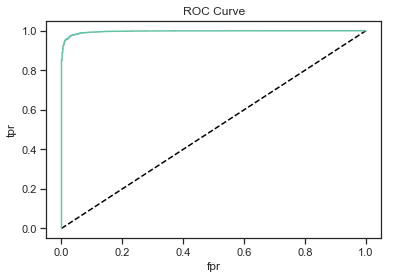

0.9966166816334732

In [9]:
y_probas = xgb_model.predict_proba(X_drop)
# ROC on train set... need to predict on test set
fpr, tpr, thresholds = roc_curve(y, y_probas[:, 1])

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='NB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.show()

roc_auc_score(y, y_probas[:, 1])

In [10]:
y_probas = xgb_model.predict_proba(test_drop)
y_probas[:,1]

array([0.892004 , 0.8387902, 0.9995759, ..., 0.9989661, 0.9237989,
       0.9491976], dtype=float32)

In [11]:
submission = pd.DataFrame({'Id':test.index,'Y':y_probas[:,1]}).set_index('Id')

In [12]:
submission.to_csv('submission.csv')

### This model gave me the highest training AUC, but the test AUC score on Kaggle was only 0.87419, which is still not as good as my best model. I would assume that because the training AUC is almost 1, the model overfitted to the data, which probably increased the avoidable variance. This is why the Kaggle AUC is lower.

# RandomizedSearchCV

### I then realized there there are L1 and L2 parameters that you can set... reg_alpha and reg_lambda, so I decided to search through those values.

In [2]:
df = pd.read_csv('train_final.csv', index_col='Id')
y = df['Y']
X = df.drop('Y', axis=1)

In [10]:
max_depth=[24]
min_child_weight=[1,2,3,4,5,6,7,8,9,10]
gamma=[1,2,3,4,5,6,7,8,9,10]
scale_pos_weight=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
subsample=[0.1,0.2,0.3,0.4,0.5,0.6]
n_estimators=[1500]
max_delta_step=[0,1,2,3,4,5,6,7,8,9,10]
learning_rate=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
colsample_bylevel=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
colsample_bytree=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
reg_alpha=[1,5,10,100,1000]
reg_lambda=[1,5,10,100,1000]
n_jobs=[-1]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'gamma': gamma,
               'scale_pos_weight': scale_pos_weight,
               'min_child_weight': min_child_weight,
               'subsample': subsample,
               'max_delta_step': max_delta_step,
               'learning_rate': learning_rate,
               'colsample_bylevel': colsample_bylevel,
               'colsample_bytree': colsample_bytree,
               'reg_alpha': reg_alpha,
               'reg_lambda': reg_lambda,
               'n_jobs': n_jobs}

search = RandomizedSearchCV(XGBClassifier(), param_distributions=random_grid, 
                            n_iter=200, scoring='roc_auc', 
                            n_jobs=-1, refit=True, cv=3, verbose=10, 
                            random_state=None, return_train_score=True)

search.fit(X, y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  6

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=200, n_jobs=-1,
          param_distributions={'n_estimators': [1500], 'max_depth': [24], 'gamma': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'scale_pos_weight': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 'max_delta_step': [0, 1, 2...8, 0.9, 1], 'reg_alpha': [1, 5, 10, 100, 1000], 'reg_lambda': [1, 5, 10, 100, 1000], 'n_jobs': [-1]},
          pre_dispatch='2*n_jobs', random_state=None, re

In [11]:
print(search.best_params_)
print(search.best_score_)
print(search.best_estimator_)

{'subsample': 0.6, 'scale_pos_weight': 1, 'reg_lambda': 10, 'reg_alpha': 1, 'n_jobs': -1, 'n_estimators': 1500, 'min_child_weight': 2, 'max_depth': 24, 'max_delta_step': 1, 'learning_rate': 0.05, 'gamma': 1, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.2}
0.8649308246505355
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.2,
       colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_delta_step=1,
       max_depth=24, min_child_weight=2, missing=None, n_estimators=1500,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=1, reg_lambda=10, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)


### This randomized hyperparameter search found that reg_alpha = 1 and reg_lamda = 10 were the best regularization values, but the Kaggle AUC was 0.84601. This score is a lot less than my best model. I think what happened here is that the regularization strength was too strong, so it also decreased the test accuracy by a lot.

# Trying again...

In [4]:
max_depth=[24]
min_child_weight=[1,2]
gamma=[8,9,10]
scale_pos_weight=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
subsample=[0.6]
n_estimators=[1500]
max_delta_step=[0,1,2,3,4,5,6,7,8,9,10]
learning_rate=[0.02,0.04,0.06,0.08,0.1]
colsample_bylevel=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
colsample_bytree=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
reg_alpha=[1,5,10,50,100,1000]
reg_lambda=[1,5,10,50,100,1000]
n_jobs=[-1]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'gamma': gamma,
               'scale_pos_weight': scale_pos_weight,
               'min_child_weight': min_child_weight,
               'subsample': subsample,
               'max_delta_step': max_delta_step,
               'learning_rate': learning_rate,
               'colsample_bylevel': colsample_bylevel,
               'colsample_bytree': colsample_bytree,
               'reg_alpha': reg_alpha,
               'reg_lambda': reg_lambda,
               'n_jobs': n_jobs}

search = RandomizedSearchCV(XGBClassifier(), param_distributions=random_grid, 
                            n_iter=216, scoring='roc_auc', 
                            n_jobs=-1, refit=True, cv=3, verbose=10, 
                            random_state=None, return_train_score=True)

search.fit(X, y)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  7

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=216, n_jobs=-1,
          param_distributions={'n_estimators': [1500], 'max_depth': [24], 'gamma': [8, 9, 10], 'scale_pos_weight': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'min_child_weight': [1, 2], 'subsample': [0.6], 'max_delta_step': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'learning_rate': [0.02, 0.04, 0.06, 0.08, 0...1], 'reg_alpha': [1, 5, 10, 50, 100, 1000], 'reg_lambda': [1, 5, 10, 50, 100, 1000], 'n_jobs': [-1]},
          pre_dispatch='2*n_jobs', random_state=None, re

In [5]:
print(search.best_params_)
print(search.best_score_)
print(search.best_estimator_)

{'subsample': 0.6, 'scale_pos_weight': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_jobs': -1, 'n_estimators': 1500, 'min_child_weight': 2, 'max_depth': 24, 'max_delta_step': 4, 'learning_rate': 0.1, 'gamma': 8, 'colsample_bytree': 1, 'colsample_bylevel': 0.8}
0.8604413977767117
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=1, gamma=8, learning_rate=0.1, max_delta_step=4,
       max_depth=24, min_child_weight=2, missing=None, n_estimators=1500,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=1, reg_lambda=1, scale_pos_weight=0.8,
       seed=None, silent=True, subsample=0.6)


# Again

In [3]:
max_depth=[24]
min_child_weight=[1,2]
gamma=[9]
scale_pos_weight=[0.8]
subsample=[0.6]
n_estimators=[1500]
max_delta_step=[0,1,2,3,4,5,6,7,8,9,10]
learning_rate=[0.02,0.04,0.06,0.08,0.1]
colsample_bylevel=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
colsample_bytree=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
reg_alpha=[0,1,2,3,4,5]
reg_lambda=[1,2,3,4,5]
n_jobs=[-1]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'gamma': gamma,
               'scale_pos_weight': scale_pos_weight,
               'min_child_weight': min_child_weight,
               'subsample': subsample,
               'max_delta_step': max_delta_step,
               'learning_rate': learning_rate,
               'colsample_bylevel': colsample_bylevel,
               'colsample_bytree': colsample_bytree,
               'reg_alpha': reg_alpha,
               'reg_lambda': reg_lambda,
               'n_jobs': n_jobs}

search = RandomizedSearchCV(XGBClassifier(), param_distributions=random_grid, 
                            n_iter=60, scoring='roc_auc', 
                            n_jobs=-1, refit=True, cv=3, verbose=10, 
                            random_state=None, return_train_score=True)

search.fit(X, y)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 13

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=60, n_jobs=-1,
          param_distributions={'n_estimators': [1500], 'max_depth': [24], 'gamma': [9], 'scale_pos_weight': [0.8], 'min_child_weight': [1, 2], 'subsample': [0.6], 'max_delta_step': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'learning_rate': [0.02, 0.04, 0.06, 0.08, 0.1], 'colsample_bylevel': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'reg_alpha': [0, 1, 2, 3, 4, 5], 'reg_lambda': [1, 2, 3, 4, 5], 'n

In [4]:
print(search.best_params_)
print(search.best_score_)
print(search.best_estimator_)

{'subsample': 0.6, 'scale_pos_weight': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_jobs': -1, 'n_estimators': 1500, 'min_child_weight': 1, 'max_depth': 24, 'max_delta_step': 10, 'learning_rate': 0.02, 'gamma': 9, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.6}
0.8651764442968265
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
       colsample_bytree=0.3, gamma=9, learning_rate=0.02,
       max_delta_step=10, max_depth=24, min_child_weight=1, missing=None,
       n_estimators=1500, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.8, seed=None, silent=True,
       subsample=0.6)


# In the end, I ran RandomizedSearchCV again, and it found that that reg_lambda = 1 and reg_alpha = 0 were the best parameters to use (these are the default values of XGBClassifier, so I guess regularizing this model wasn't necessary. It also makes sense too because my best model was a model without adding any regularization.